In [189]:
import json
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import multiprocessing
import numpy as np
from wit import Wit
import pandas_profiling
import shutil 
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# load and run helper functions
%load "fad_diets_functions.py"

## Read in data to pandas df

In [1]:
#Combine all files into one

# with open('output_file.txt','wb') as wfd:
#     for f in ['twitter_data.txt','twitter_data_c2.txt', 'twitter_data_c2_pt2.txt','twitter_data_c2_pt3.txt', 'twitter_data_c2_pt4.txt', 'twitter_data_c2_pt5.txt', 'twitter_data_c2_pt6.txt', 'twitter_data_c2_pt7.txt']:
#         with open(f,'rb') as fd:
#             shutil.copyfileobj(fd, wfd)

In [303]:
#Read in data OLD
# tweets_data_path = 'output_file_test.txt'

# tweets_data = []
# words = []
# tweets_file = open(tweets_data_path, "r")
# for line in tweets_file:
#     try:
#         tweet = json.loads(line)
#         tweets_data.append(tweet)
#     except:
#         continue

In [388]:
#read in data as chunks
df = pd.read_json('twitter_data_c2_pt2.txt', lines = True)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 36 columns):
contributors                 0 non-null float64
coordinates                  30 non-null object
created_at                   3387 non-null datetime64[ns]
display_text_range           1013 non-null object
entities                     3387 non-null object
extended_entities            320 non-null object
extended_tweet               1181 non-null object
favorite_count               3387 non-null int64
favorited                    3387 non-null bool
filter_level                 3387 non-null object
geo                          30 non-null object
id                           3387 non-null int64
id_str                       3387 non-null int64
in_reply_to_screen_name      500 non-null object
in_reply_to_status_id        462 non-null float64
in_reply_to_status_id_str    462 non-null float64
in_reply_to_user_id          500 non-null float64
in_reply_to_user_id_str      500 non-null float6

In [389]:
#only keep variables needed
df = df[["id_str", "text", "place", "coordinates", "created_at", "lang", "possibly_sensitive","retweeted" ]]

In [390]:
def keyword_column_boolean(df, keyword_list):
    for x in keyword_list:
        df[x] = df['text'].apply(lambda text: word_in_text(x,text))

In [392]:
#don't include retweets
keyword_column_boolean(df, ['RT'])
print("before RT removal:", len(df))
df = df[df['RT']==False]
print("after RT removal:", len(df))

before RT removal: 3387
after RT removal: 1867


In [395]:
#booleans for each diet
diet_list = ['keto','whole30','glutenfree','mediterraneandiet','lowfat', 'atkins', 'paleo', 'celeryjuice']
keyword_column_boolean(df, diet_list)

In [396]:
df.head(1)

,id_str,text,place,coordinates,created_at,lang,possibly_sensitive,retweeted,RT,keto,whole30,glutenfree,mediterraneandiet,lowfat,atkins,paleo,celeryjuice
0,1141553393959239680,"@majilato @SuperMugatu Damn right, and he's fu...",0,None,2019-06-20 03:48:32,en,NaN,False,False,True,False,False,False,False,False,False,False


In [417]:
#fix Place field
#fill None with 0
filled = df['place'].fillna(0)
#replace old column
df["place"] = filled
# #mask
place = df[df['place'] != 0]
place.reset_index(inplace=True)

#pull out bounding box from place
df_place = [i for i in df["place"] if i] 
df_place_2 = pd.DataFrame(list(np.array(df_place)))

city = df_place_2[["name","country_code"]]

bounding_box = pd.DataFrame(list(np.array(df_place_2["bounding_box"])))
bounding_box.rename(columns={'coordinates': 'bounding_box'}, inplace=True)

In [418]:
#add to original df to get df we want
df_location = pd.concat([place, bounding_box], axis=1, join='inner')
df_location = pd.concat([df_location, city], axis=1, join='inner')
print("before english removal:", len(df_location))

before english removal: 84


In [420]:
#limit to only english for analysis
df_location = df_location[df_location['lang'] == 'en']
print("after english removal:", len(df_location))

after english removal: 70


In [422]:
#limit to only US for analysis
df_location = df_location[df_location['country_code'] == 'US']
print("after non-US removal:", len(df_location))

after non-US removal: 34


In [76]:
#clean tweets of URLs
import preprocessor as p

In [423]:
p.set_options(p.OPT.URL, p.OPT.SMILEY, p.OPT.MENTION) #remove URLs, smileys, mentions but keep emojis


text_list = list(df_location["text"])

clean_text_list = []
for tweet in text_list:   
    clean_text_list.append(p.clean(tweet))

df_location["text_clean"] = clean_text_list 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [424]:
#fix index
df_location2 = df_location.reset_index()
df_location3 = df_location2.drop(["index", "level_0"], axis = 1)
df_location3['index'] = df_location3.index
df_location3.head()

,id_str,text,place,coordinates,created_at,lang,possibly_sensitive,retweeted,RT,keto,...,lowfat,atkins,paleo,celeryjuice,bounding_box,type,name,country_code,text_clean,index
0,1141553418944876544,It’s hard when nobody can afford food without ...,"{'id': '3faf04da3454baba', 'url': 'https://api...",None,2019-06-20 03:48:38,en,NaN,False,False,False,...,False,False,False,False,"[[[-82.901433, 42.578183], [-82.901433, 42.617...",Polygon,Mount Clemens,US,It’s hard when nobody can afford food without ...,0
1,1141555808351576064,Whoo hooo. Happy dance time. My June Keto Krat...,"{'id': '3df4f427b5a60fea', 'url': 'https://api...","{'type': 'Point', 'coordinates': [-98.5, 29.41...",2019-06-20 03:58:08,en,0.0,False,False,True,...,False,False,False,False,"[[[-98.778559, 29.141956], [-98.778559, 29.693...",Polygon,San Antonio,US,Whoo hooo. Happy dance time. My June Keto Krat...,1
2,1141558859003129856,@Jasperr____ get the keto coffee ones 🤪,"{'id': '1193edda55d6fa3d', 'url': 'https://api...",None,2019-06-20 04:10:15,en,NaN,False,False,True,...,False,False,False,False,"[[[-117.967313, 34.001861], [-117.967313, 34.0...",Polygon,West Covina,US,get the keto coffee ones 🤪,2
3,1141567158788468736,Gotta try this keto diet shits,"{'id': '67b98f17fdcf20be', 'url': 'https://api...",None,2019-06-20 04:43:14,en,NaN,False,False,True,...,False,False,False,False,"[[[-71.191421, 42.227797], [-71.191421, 42.399...",Polygon,Boston,US,Gotta try this keto diet shits,3
4,1141571340467679232,I’LL go back on 100% keto on my bday!! \n7/1 t...,"{'id': '1711fcf6c5dcde3c', 'url': 'https://api...",None,2019-06-20 04:59:51,en,NaN,False,False,True,...,False,False,False,False,"[[[-73.285247, 40.705724000000004], [-73.28524...",Polygon,Bay Shore,US,I’LL go back on 100% keto on my bday!! 7/1 the...,4


## Topic Modeling using LDA

In [425]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS 
# Set of stopwords from Stone, Denis, Kwantes
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vinhtran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [426]:
#function to perform lemmatize and stem preprocessing
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [428]:
stemmer = PorterStemmer()

#
documents_v = df_location3[['text_clean', "index"]]
print(documents_v[:10])

                                          text_clean  index
0  It’s hard when nobody can afford food without ...      0
1  Whoo hooo. Happy dance time. My June Keto Krat...      1
2                         get the keto coffee ones 🤪      2
3                     Gotta try this keto diet shits      3
4  I’LL go back on 100% keto on my bday!! 7/1 the...      4
5  Keto Fit This will help in reducing fast weigh...      5
6  If your doing keto, eat quest bars for somethi...      6
7  Is the Keto Diet a Good Idea For Weight Loss? ...      7
8  So you're saying I can drink as much liquor as...      8
9  Keto Fit Pro work superb on human body like in...      9


In [429]:
#compare a tweet before and after preprocessing
doc_sample = documents_v[documents_v['index'] == 10].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Keto', 'fit', 'pro', 'It', 'is', 'help', 'conquer', 'laziness,', 'anxiety,', 'stress', 'that', 'occur', 'because', 'of', 'fat', 'around', 'abdomen,', 'thighs,', 'buttock…']


 tokenized and lemmatized document: 
['keto', 'help', 'conquer', 'lazi', 'anxieti', 'stress', 'occur', 'abdomen', 'thigh', 'buttock']


In [530]:
#Apply to all tweets
processed_docs = documents_v['text_clean'].map(preprocess)
processed_docs[:11]

0             [hard, afford, food, charg, credit, card]
1     [whoo, hooo, happi, danc, time, june, keto, kr...
2                                    [keto, coffe, one]
3                             [gotta, keto, diet, shit]
4                           [keto, bday, stop, graduat]
5        [keto, help, reduc, fast, weight, loss, visit]
6                       [keto, quest, bar, sweet, carb]
7     [keto, diet, good, idea, weight, loss, fee, bl...
8             [say, drink, liquor, want, keto, perfect]
9     [keto, work, superb, human, bodi, like, incred...
10    [keto, help, conquer, lazi, anxieti, stress, o...
Name: text_clean, dtype: object

In [532]:
processed_docs.head()

0            [hard, afford, food, charg, credit, card]
1    [whoo, hooo, happi, danc, time, june, keto, kr...
2                                   [keto, coffe, one]
3                            [gotta, keto, diet, shit]
4                          [keto, bday, stop, graduat]
Name: text_clean, dtype: object

In [ ]:
# Bag of Words on the Data set

In [433]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 afford
1 card
2 charg
3 credit
4 food
5 hard
6 arriv
7 danc
8 happi
9 hooo
10 june


In [434]:
# Filter out tokens that appear in
# less than 15 documents (absolute number) or
# more than 0.5 documents (fraction of total corpus size, not absolute number).
# after the above two steps, keep only the first 100000 most frequent tokens.

dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=100000)

In [435]:
print(dictionary)

Dictionary(32 unique tokens: ['food', 'hard', 'ketoapprov', 'coffe', 'diet']...)


In [436]:
#create bag of words. Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[:10]

[[(0, 1), (1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(6, 1), (7, 1), (8, 1)],
 [(9, 1)],
 [(4, 1), (7, 1), (8, 1), (10, 1), (11, 1), (12, 1)],
 [(13, 1), (14, 1)],
 [(15, 1), (16, 1)]]

In [437]:
# Preview Bag Of Words for our sample preprocessed document.
bow_doc_10 = bow_corpus[10]
for i in range(len(bow_doc_10)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_10[i][0], 
                                               dictionary[bow_doc_10[i][0]], 
bow_doc_10[i][1]))

Word 6 ("help") appears 1 time.


In [438]:
# TF-IDF
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.7071067811865476), (1, 0.7071067811865476)]


In [ ]:
# LDA using Bag of Words

In [439]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [440]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.134*"review" + 0.134*"bodi" + 0.134*"info" + 0.134*"keton" + 0.134*"ketoapprov" + 0.012*"diet" + 0.012*"coffe" + 0.012*"stop" + 0.012*"carb" + 0.012*"vegan"
Topic: 1 
Words: 0.187*"work" + 0.187*"hard" + 0.161*"vegan" + 0.098*"bodi" + 0.098*"food" + 0.035*"diet" + 0.009*"coffe" + 0.009*"stop" + 0.009*"help" + 0.009*"carb"
Topic: 2 
Words: 0.139*"weight" + 0.117*"good" + 0.117*"help" + 0.108*"loss" + 0.086*"diet" + 0.086*"fee" + 0.086*"idea" + 0.065*"product" + 0.034*"keton" + 0.034*"ketoapprov"
Topic: 3 
Words: 0.056*"diet" + 0.056*"weight" + 0.056*"idea" + 0.056*"loss" + 0.056*"carnivor" + 0.056*"fee" + 0.056*"peopl" + 0.056*"good" + 0.056*"annoy" + 0.056*"automat"
Topic: 4 
Words: 0.292*"carb" + 0.153*"breakfast" + 0.153*"carnivor" + 0.014*"diet" + 0.014*"coffe" + 0.014*"help" + 0.014*"bodi" + 0.014*"stop" + 0.014*"ketoapprov" + 0.014*"drink"
Topic: 5 
Words: 0.306*"diet" + 0.186*"stop" + 0.017*"coffe" + 0.017*"help" + 0.017*"ketoapprov" + 0.017*"bodi" + 0.017*"car

In [ ]:
# Running LDA using TF-IDF

In [441]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.142*"info" + 0.142*"stop" + 0.142*"carb" + 0.142*"ketoapprov" + 0.043*"poor" + 0.028*"everybodi" + 0.028*"money" + 0.023*"idea" + 0.013*"diet" + 0.013*"help"
Topic: 1 Word: 0.262*"help" + 0.024*"diet" + 0.024*"ketoapprov" + 0.024*"coffe" + 0.024*"vegan" + 0.024*"bodi" + 0.024*"stop" + 0.024*"carb" + 0.024*"drink" + 0.024*"work"
Topic: 2 Word: 0.223*"breakfast" + 0.127*"want" + 0.111*"carb" + 0.097*"carnivor" + 0.016*"diet" + 0.016*"help" + 0.016*"coffe" + 0.016*"vegan" + 0.016*"drink" + 0.016*"stop"
Topic: 3 Word: 0.355*"coffe" + 0.041*"fee" + 0.038*"good" + 0.038*"loss" + 0.036*"diet" + 0.036*"idea" + 0.036*"weight" + 0.017*"help" + 0.017*"carb" + 0.017*"ketoapprov"
Topic: 4 Word: 0.160*"bodi" + 0.130*"food" + 0.091*"info" + 0.091*"keton" + 0.091*"review" + 0.058*"diet" + 0.015*"coffe" + 0.015*"help" + 0.015*"ketoapprov" + 0.015*"carb"
Topic: 5 Word: 0.132*"hard" + 0.077*"annoy" + 0.077*"automat" + 0.077*"peopl" + 0.077*"great" + 0.077*"hostil" + 0.077*"food" + 0.068*

In [ ]:
# Performance Evaluation

In [442]:
processed_docs[10]

['keto',
 'help',
 'conquer',
 'lazi',
 'anxieti',
 'stress',
 'occur',
 'abdomen',
 'thigh',
 'buttock']

In [443]:
# Performance evaluation by classifying sample document using LDA TF-IDF model.
for index, score in sorted(lda_model[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.5499984622001648	 
Topic: 0.139*"weight" + 0.117*"good" + 0.117*"help" + 0.108*"loss" + 0.086*"diet" + 0.086*"fee" + 0.086*"idea" + 0.065*"product" + 0.034*"keton" + 0.034*"ketoapprov"

Score: 0.050001002848148346	 
Topic: 0.227*"poor" + 0.116*"idea" + 0.116*"money" + 0.116*"everybodi" + 0.116*"want" + 0.061*"breakfast" + 0.061*"drink" + 0.022*"help" + 0.022*"weight" + 0.022*"loss"

Score: 0.05000006780028343	 
Topic: 0.134*"review" + 0.134*"bodi" + 0.134*"info" + 0.134*"keton" + 0.134*"ketoapprov" + 0.012*"diet" + 0.012*"coffe" + 0.012*"stop" + 0.012*"carb" + 0.012*"vegan"

Score: 0.05000006780028343	 
Topic: 0.187*"work" + 0.187*"hard" + 0.161*"vegan" + 0.098*"bodi" + 0.098*"food" + 0.035*"diet" + 0.009*"coffe" + 0.009*"stop" + 0.009*"help" + 0.009*"carb"

Score: 0.05000006780028343	 
Topic: 0.056*"diet" + 0.056*"weight" + 0.056*"idea" + 0.056*"loss" + 0.056*"carnivor" + 0.056*"fee" + 0.056*"peopl" + 0.056*"good" + 0.056*"annoy" + 0.056*"automat"

Score: 0.05000006780028343

## NLP Sentiment Analysis

In [460]:
from textblob import TextBlob

In [462]:
documents_v['text_clean'][0]

'It’s hard when nobody can afford food without charging it to a credit card at 24% APR'

In [477]:
def get_tweet_polarity(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet)
        # set sentiment 
        return analysis.sentiment.polarity
    
def get_tweet_sentiment(polarity): 
        if polarity > 0: 
            return 'positive'
        elif polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

In [480]:
documents_v['polarity'] = documents_v['text_clean'].map(get_tweet_polarity);
documents_v['sentiment'] = documents_v['polarity'].map(get_tweet_sentiment);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [496]:
# picking positive tweets from tweets 
ptweets = documents_v[documents_v['sentiment'] == 'positive']
# percentage of positive tweets 
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(documents_v))) 
# picking negative tweets from tweets 
ntweets = documents_v[documents_v['sentiment'] == 'negative']
# percentage of negative tweets 
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(documents_v))) 
# percentage of neutral tweets 
print("Neutral tweets percentage: {} %".format(100* (len(documents_v) - len(ntweets) - len(ptweets))/len(documents_v)))
  

Positive tweets percentage: 52.94117647058823 %
Negative tweets percentage: 23.529411764705884 %
Neutral tweets percentage: 23.529411764705884 %


In [541]:
processed_docs = processed_docs.rename(columns = {"clean_text": 'text_tokenized'})

In [612]:
documents_v.head()

,text_clean,index,sentiment,polarity
0,It’s hard when nobody can afford food without ...,0,negative,-0.291667
1,Whoo hooo. Happy dance time. My June Keto Krat...,1,positive,0.525000
2,get the keto coffee ones 🤪,2,neutral,0.000000
3,Gotta try this keto diet shits,3,neutral,0.000000
4,I’LL go back on 100% keto on my bday!! 7/1 the...,4,neutral,0.000000


In [589]:
positive_tweets = pd.concat([processed_docs,ptweets], axis=1, join='inner')
negative_tweets = pd.concat([processed_docs,ntweets], axis=1, join='inner')                         


In [590]:
positive_tweets = positive_tweets.rename(columns = {0: 'text_tokenized'})
negative_tweets = negative_tweets.rename(columns = {0: 'text_tokenized'})

In [591]:
import itertools 

all_p_text = []
for word in positive_tweets['text_tokenized']:
    all_p_text.append(word)
all_p_text = list(itertools.chain.from_iterable(all_p_text))
print(all_p_text)

all_n_text = []
for word in negative_tweets['text_tokenized']:
    all_n_text.append(word)
all_n_text = list(itertools.chain.from_iterable(all_n_text))
print(all_n_text)

['whoo', 'hooo', 'happi', 'danc', 'time', 'june', 'keto', 'krate', 'arriv', 'ketokr', 'ketoapprov', 'keto', 'help', 'reduc', 'fast', 'weight', 'loss', 'visit', 'keto', 'quest', 'bar', 'sweet', 'carb', 'keto', 'diet', 'good', 'idea', 'weight', 'loss', 'fee', 'blackceo', 'say', 'drink', 'liquor', 'want', 'keto', 'perfect', 'keto', 'work', 'superb', 'human', 'bodi', 'like', 'incred', 'boost', 'metabol', 'rate', 'breakdown', 'store', 'stubborn', 'keto', 'help', 'conquer', 'lazi', 'anxieti', 'stress', 'occur', 'abdomen', 'thigh', 'buttock', 'keto', 'review', 'substanc', 'normal', 'call', 'keton', 'bodi', 'info', 'keto', 'shark', 'tank', 'help', 'product', 'keton', 'compound', 'bodi', 'prevent', 'extra', 'weight', 'treat', 'diabet', 'keto', 'review', 'help', 'avoid', 'accumul', 'molecul', 'affect', 'brain', 'caus', 'keto', 'burn', 'supplement', 'pack', 'veggi', 'capsul', 'info', 'keto', 'grow', 'love', 'tequila', 'tonic', 'keto', 'diet', 'good', 'idea', 'weight', 'loss', 'fee', 'missingdcgir

In [594]:
BOW_p = nltk.FreqDist(all_p_text)
BOW_n = nltk.FreqDist(all_n_text)

In [596]:
# listing the 10 most frequent words
word_features_p = list(BOW_p.keys())[:10]
print(word_features_p[0], word_features_p[-1])
# listing the 10 most frequent words
word_features_n = list(BOW_n.keys())[:10]
print(word_features_n[0], word_features_n[-1])

whoo ketokr
hard everybodi


In [599]:
def bag_of_words(tweet):
    words = all_text
    words_dictionary = dict([word, True] for word in words)    
    return words_dictionary


# positive tweets feature set
pos_tweets_set = []
for tweet in positive_tweets["text_clean"]:
    pos_tweets_set.append((bag_of_words(tweet), 'pos'))   
    
neg_tweets_set = []
for tweet in negative_tweets["text_clean"]:
    neg_tweets_set.append((bag_of_words(tweet), 'neg')) 
    
print (len(pos_tweets_set), len(neg_tweets_set))

18 8


In [602]:
test_set = pos_tweets_set[:int(18*.2)] + neg_tweets_set[:int(8*.2)]
train_set = pos_tweets_set[int(18*.2):] + neg_tweets_set[int(18*.2):]

print(len(test_set),  len(train_set))

4 20


In [603]:

from nltk import classify
from nltk import NaiveBayesClassifier
 
classifier = NaiveBayesClassifier.train(train_set)
 
accuracy = classify.accuracy(classifier, test_set)
print(accuracy) # Output: 0.765
 
print (classifier.show_most_informative_features(10)) 

0.75
Most Informative Features
                   boost = True              neg : pos    =      1.0 : 1.0
                 prevent = True              neg : pos    =      1.0 : 1.0
                     bar = True              neg : pos    =      1.0 : 1.0
                  delici = True              neg : pos    =      1.0 : 1.0
                 perfect = True              neg : pos    =      1.0 : 1.0
                    idea = True              neg : pos    =      1.0 : 1.0
                stubborn = True              neg : pos    =      1.0 : 1.0
                    burn = True              neg : pos    =      1.0 : 1.0
                carnivor = True              neg : pos    =      1.0 : 1.0
                    info = True              neg : pos    =      1.0 : 1.0
None


In [604]:
from collections import defaultdict
 
actual_set = defaultdict(set)
predicted_set = defaultdict(set)
 
actual_set_cm = []
predicted_set_cm = []
 
for index, (feature, actual_label) in enumerate(test_set):
    actual_set[actual_label].add(index)
    actual_set_cm.append(actual_label)
 
    predicted_label = classifier.classify(feature)
 
    predicted_set[predicted_label].add(index)
    predicted_set_cm.append(predicted_label)
    
from nltk.metrics import precision, recall, f_measure, ConfusionMatrix

In [607]:
print('pos precision:', precision(actual_set['pos'], predicted_set['pos']))
print('pos recall:', recall(actual_set['pos'], predicted_set['pos']))
print('pos F-measure:', f_measure(actual_set['pos'], predicted_set['pos']))
print('neg precision:', precision(actual_set['neg'], predicted_set['neg']))
print('neg recall:', recall(actual_set['neg'], predicted_set['neg']))
print('neg F-measure:', f_measure(actual_set['neg'], predicted_set['neg']))

pos precision: 0.75
pos recall: 1.0
pos F-measure: 0.8571428571428572
neg precision: None
neg recall: 0.0
neg F-measure: None


In [609]:
print (cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

    |      p      n |
    |      o      e |
    |      s      g |
----+---------------+
pos | <75.0%>     . |
neg |  25.0%     <.>|
----+---------------+
(row = reference; col = test)



## Explore COORDINATES - use to map

In [446]:
#fix coordinates field
#fill None with 0
filled = df['coordinates'].fillna(0)
#replace old column
df["coordinates"] = filled
#mask
coordinates = df[df['coordinates'] != 0]

#keep only needed vars;
coordinates = coordinates[["text","coordinates", "created_at", "lang", "possibly_sensitive", "id_str"]].reset_index()

#create separate lon and lat columns
coordinates_pd = pd.DataFrame(list(np.array(coordinates["coordinates"])))
coordinates_pd.rename(columns={'coordinates': 'coordinate_point'}, inplace=True)
df_coordinates = pd.concat([coordinates, coordinates_pd], axis=1, join='inner')
df_coordinates[['lon', 'lat']] = pd.DataFrame(df_coordinates['coordinate_point'].tolist())



In [448]:
def generateBaseMap(default_location=[29.4167, -98.5], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

base_map = generateBaseMap()

from folium.plugins import HeatMap
df_coordinates["count"] = 1
HeatMap(data=df_coordinates[['lat', 'lon', 'count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

base_map

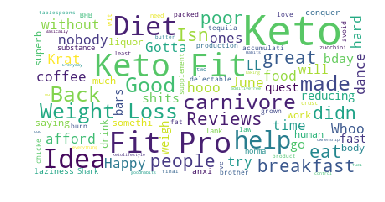

In [506]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
# % matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=STOPWORDS,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(documents_v["text_clean"]))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

# But I want to make some sort of prediction!

In [677]:
cities = pd.read_csv('500_Cities__City-level_Data__GIS_Friendly_Format___2018_release.csv')
cities.head()


,StateAbbr,PlaceName,PlaceFIPS,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ACCESS2_AdjPrev,ACCESS2_Adj95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,SLEEP_Adj95CI,STROKE_CrudePrev,STROKE_Crude95CI,STROKE_AdjPrev,STROKE_Adj95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,TEETHLOST_AdjPrev,TEETHLOST_Adj95CI,Geolocation
0,CA,Folsom,624638,72203,7.5,"( 7.0, 8.0)",7.7,"( 7.2, 8.2)",16.9,"(16.6, 17.2)",...,"(32.7, 33.5)",1.9,"( 1.9, 2.0)",2.0,"( 2.0, 2.1)",6.8,"( 5.7, 8.0)",6.8,"( 5.7, 7.9)","(38.67504943280, -121.147605753)"
1,FL,Largo,1239425,77648,19.6,"(19.1, 20.2)",20.9,"(20.4, 21.5)",30.6,"(30.3, 30.9)",...,"(39.5, 40.1)",4.5,"( 4.4, 4.7)",3.2,"( 3.2, 3.3)",18.3,"(16.9, 19.8)",18.0,"(16.7, 19.4)","(27.90909077340, -82.7714203383)"
2,CA,Berkeley,606000,112580,7.7,"( 7.3, 8.1)",7.1,"( 6.8, 7.3)",15.1,"(15.0, 15.3)",...,"(32.3, 32.7)",1.9,"( 1.8, 1.9)",2.3,"( 2.2, 2.3)",6.7,"( 6.2, 7.2)",6.8,"( 6.3, 7.4)","(37.87256787650, -122.274907975)"
3,CA,Napa,650258,76915,12.3,"(11.8, 12.8)",12.7,"(12.1, 13.3)",20.7,"(20.5, 21.0)",...,"(32.7, 33.3)",2.8,"( 2.7, 2.9)",2.6,"( 2.5, 2.7)",11.2,"(10.0, 12.5)",11.2,"(10.0, 12.3)","(38.29804246490, -122.301093331)"
4,FL,Sunrise,1269700,84439,22.8,"(22.1, 23.5)",23.3,"(22.6, 24.1)",22.8,"(22.5, 23.1)",...,"(38.3, 38.8)",3.7,"( 3.5, 3.8)",3.3,"( 3.2, 3.4)",16.2,"(14.3, 18.5)",15.8,"(14.2, 17.7)","(26.15468783030, -80.2998411020)"


In [697]:
from geopy.geocoders import Nominatim

In [700]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("29.4167, -98.5")
print(location.address)

824, South Laredo Street, Arsenal, San Antonio, Bexar County, Texas, 78204, USA


In [757]:

#get help with this!!!

 def find_centroid(row):
    '''
    Helper function to return the centroid of a polygonal bounding box of longitude, latitude coordinates
    '''
    
    try:
        row_ = eval(row)
        lst_of_coords = [item for sublist in row_ for item in sublist]
        longitude = [p[0] for p in lst_of_coords]
        latitude = [p[1] for p in lst_of_coords]
        return (sum(latitude) / float(len(latitude)), sum(longitude) / float(len(longitude)))
        
    except:
        return None


# Create a new column called 'centroid' 
df_location3['centroid'] = list(map(lambda row: find_centroid(row), df_location3['bounding_box']))

In [766]:
df_location["bounding_box"][1]

[[[-98.778559, 29.141956],
  [-98.778559, 29.693046],
  [-98.302744, 29.693046],
  [-98.302744, 29.141956]]]

In [768]:
list2 = [item[0] for item in df_location["bounding_box"][1]]

In [769]:
list2

[[-98.778559, 29.141956]]

In [750]:
df_location3.head()

,id_str,text,place,coordinates,created_at,lang,possibly_sensitive,retweeted,RT,keto,...,atkins,paleo,celeryjuice,bounding_box,type,name,country_code,text_clean,index,centroid
0,1141553418944876544,It’s hard when nobody can afford food without ...,"{'id': '3faf04da3454baba', 'url': 'https://api...",None,2019-06-20 03:48:38,en,NaN,False,False,False,...,False,False,False,"[[[-82.901433, 42.578183], [-82.901433, 42.617...",Polygon,Mount Clemens,US,It’s hard when nobody can afford food without ...,0,None
1,1141555808351576064,Whoo hooo. Happy dance time. My June Keto Krat...,"{'id': '3df4f427b5a60fea', 'url': 'https://api...","{'type': 'Point', 'coordinates': [-98.5, 29.41...",2019-06-20 03:58:08,en,0.0,False,False,True,...,False,False,False,"[[[-98.778559, 29.141956], [-98.778559, 29.693...",Polygon,San Antonio,US,Whoo hooo. Happy dance time. My June Keto Krat...,1,None
2,1141558859003129856,@Jasperr____ get the keto coffee ones 🤪,"{'id': '1193edda55d6fa3d', 'url': 'https://api...",None,2019-06-20 04:10:15,en,NaN,False,False,True,...,False,False,False,"[[[-117.967313, 34.001861], [-117.967313, 34.0...",Polygon,West Covina,US,get the keto coffee ones 🤪,2,None
3,1141567158788468736,Gotta try this keto diet shits,"{'id': '67b98f17fdcf20be', 'url': 'https://api...",None,2019-06-20 04:43:14,en,NaN,False,False,True,...,False,False,False,"[[[-71.191421, 42.227797], [-71.191421, 42.399...",Polygon,Boston,US,Gotta try this keto diet shits,3,None
4,1141571340467679232,I’LL go back on 100% keto on my bday!! \n7/1 t...,"{'id': '1711fcf6c5dcde3c', 'url': 'https://api...",None,2019-06-20 04:59:51,en,NaN,False,False,True,...,False,False,False,"[[[-73.285247, 40.705724000000004], [-73.28524...",Polygon,Bay Shore,US,I’LL go back on 100% keto on my bday!! 7/1 the...,4,None


In [ ]:
row_ = eval(row)
lst_of_coords = [item for sublist in row_ for item in sublist]
longitude = [p[0] for p in lst_of_coords]
latitude = [p[1] for p in lst_of_coords]
return (sum(latitude) / float(len(latitude)), sum(longitude) / float(len(longitude)))

In [721]:
df_location3.head(1)

,id_str,text,place,coordinates,created_at,lang,possibly_sensitive,retweeted,RT,keto,...,atkins,paleo,celeryjuice,bounding_box,type,name,country_code,text_clean,index,centroid
0,1141553418944876544,It’s hard when nobody can afford food without ...,"{'id': '3faf04da3454baba', 'url': 'https://api...",None,2019-06-20 03:48:38,en,NaN,False,False,False,...,False,False,False,"[[[-82.901433, 42.578183], [-82.901433, 42.617...",Polygon,Mount Clemens,US,It’s hard when nobody can afford food without ...,0,<map object at 0x1a23302c50>


In [724]:
print(df_location3["centroid"][0])

In [732]:
pkl_file = open("GeoData/US_coord_dict.pkl", 'rb')
US_coord_dict = pickle.load(pkl_file)
US_coord_dict

d={}
for key, value in US_coord_dict.items():
    print(key,value)

Mesquite, TX (32.7749375, -96.60214250000001)
Arvada, CO (39.8202065, -105.12818850000001)
South Bend, IN (41.679655499999996, -86.290863)
Bend, OR (44.059938, -121.311582)
Cicero, IL (41.843776, -87.75880049999999)
Fremont, CA (37.5236445, -121.979527)
Norwalk, CA (33.9072505, -118.0767455)
Norwalk, CT (41.1562815, -73.4409395)
Hayward, CA (37.641270500000005, -122.0857755)
Murrieta, CA (33.5669805, -117.1965255)
Rancho Cucamonga, CA (34.12167, -117.5621525)
Sandy, UT (40.572455500000004, -111.8609655)
Oxnard, CA (34.181956, -119.165389)
Fort Lauderdale, FL (26.150368, -80.1491725)
Nashua, NH (42.752969500000006, -71.50411700000001)
Reading, PA (40.3341185, -75.9250215)
Racine, WI (42.738642999999996, -87.82412550000001)
Spokane, WA (47.667438, -117.43454699999998)
Bellingham, WA (48.753352500000005, -122.430277)
Bakersfield, CA (35.3469015, -119.025163)
Lowell, MA (42.636248, -71.326858)
Gainesville, FL (29.673171500000002, -82.3302695)
Athens, GA (33.9563835, -83.3997795)
Lawton, OK

In [734]:
def find_dist_between(tup1, tup2):
    '''
    INPUT: Two tuples of latitude, longitude coordinates pairs for two cities
    OUTPUT: The distance between the cities
    '''
    
    return np.sqrt((tup1[0] - tup2[0])**2 + (tup1[1] - tup2[1])**2)
find_dist_between((48.753352500000005, -122.430277), (40.3341185, -75.9250215))

47.261213381239344

In [739]:
import numpy as np
import pickle

def load_US_coord_dict():
    '''
    Input: n/a
    Output: A dictionary whose keys are the location names ('City, State') of the 
    378 US classification locations and the values are the centroids for those locations
    (latitude, longittude)
    '''

    pkl_file = open("GeoData/US_coord_dict.pkl", 'rb')
    US_coord_dict = pickle.load(pkl_file)
    pkl_file.close()
    return US_coord_dict

def find_dist_between(tup1, tup2):
    '''
    INPUT: Two tuples of latitude, longitude coordinates pairs for two cities
    OUTPUT: The distance between the cities
    '''
    
    return np.sqrt((tup1[0] - tup2[0])**2 + (tup1[1] - tup2[1])**2)

def closest_major_city(tup):
    '''
    INPUT: A tuple of the centroid coordinates for the tweet to remap to the closest major city
    OUTPUT: String, 'City, State', of the city in the dictionary 'coord_dict' that is closest to the input city 
    '''
    
    d={}
    for key, value in US_coord_dict.items():
        dist = find_dist_between(tup, value)
        if key not in d:
            d[key] = dist
    return min(d, key=d.get)

def get_closest_major_city_for_US(row):
    '''
    Helper function to return the closest major city for US users only. For users
    outside the US it returns 'NOT_IN_US, NONE' 
    '''
    
#     if row['geo_location'] == 'NOT_IN_US, NONE':
#         return 'NOT_IN_US, NONE'
#     else:
    return closest_major_city(row['centroid'])
    
if __name__ == "__main__":

    # Load US_coord_dict
    US_coord_dict = load_US_coord_dict()

    # Create a new column called 'closest_major_city'
    df_location3['closest_major_city'] = df_location3.apply(lambda row: get_closest_major_city_for_US(row), axis=1)
    

KeyError: ('centroid', 'occurred at index id_str')

In [740]:
# find nearest city using bouding_box
bounding_box = df_location3["bounding_box"]
bounding_box

0     [[[-82.901433, 42.578183], [-82.901433, 42.617...
1     [[[-98.778559, 29.141956], [-98.778559, 29.693...
2     [[[-117.967313, 34.001861], [-117.967313, 34.0...
3     [[[-71.191421, 42.227797], [-71.191421, 42.399...
4     [[[-73.285247, 40.705724000000004], [-73.28524...
5     [[[-79.76259, 40.477383], [-79.76259, 45.01585...
6     [[[-95.438435, 29.497739], [-95.438435, 29.598...
7     [[[-96.234587, 41.175884], [-96.234587, 41.375...
8     [[[-121.416872, 37.883347], [-121.416872, 38.0...
9     [[[-179.231086, 13.182335], [-179.231086, 71.4...
10    [[[-84.820309, 38.403186], [-84.820309, 42.327...
11    [[[-89.57151, 36.497129], [-89.57151, 39.14735...
12    [[[-88.097892, 37.771743], [-88.097892, 41.761...
13    [[[-90.418108, 41.696088], [-90.418108, 48.306...
14    [[[-95.774704, 35.995476], [-95.774704, 40.613...
15    [[[-91.51308, 36.970298], [-91.51308, 42.50830...
16    [[[-91.51308, 36.970298], [-91.51308, 42.50830...
17    [[[-118.668404, 33.704538], [-118.668404, 

In [691]:
# clean DF to use is df_location3 and document_v for scores
# documents_v.drop(['text_clean'] ,axis=1, inplace=True)
prediction = pd.concat([df_location3, documents_v], axis=1)
prediction2 = prediction.groupby(['name','sentiment'])['polarity'].mean()
prediction2 = pd.DataFrame(prediction2)
prediction3 = prediction2.pivot_table(index='name', columns="sentiment", values='polarity')
prediction3 =  prediction3.rename_axis(None, axis=1).reset_index() 
prediction4 = prediction3.rename(columns = {"index": 'PlaceName'})

In [694]:
prediction4

,name,negative,neutral,positive
0,Bay Shore,NaN,0.0,NaN
1,Bayonne,NaN,0.0,NaN
2,Boston,NaN,0.0,NaN
3,Denver,NaN,0.0,NaN
4,Forsyth,-0.200000,NaN,NaN
5,Illinois,-0.266667,NaN,NaN
6,Indiana,NaN,NaN,0.200
7,Kansas,NaN,0.0,NaN
8,Kentucky,NaN,NaN,0.350
9,Lake Mary,NaN,NaN,0.200


In [692]:
prediction5 = pd.merge(prediction4, cities, left_on='PlaceName', right_on='PlaceName')

KeyError: 'PlaceName'

KeyError: "['level_0'] not found in axis"

In [ ]:
#merge to cities 